<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/Diabetes_Detection_Using_CNN/blob/main/5-Fold_Cross-Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install keras-tuner --quiet
!pip install imbalanced-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=columns)

# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Define SAE for data augmentation
def build_sae(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim * 2, activation="relu")(input_layer)
    encoded = Dense(encoding_dim, activation="relu")(encoded)
    decoded = Dense(encoding_dim * 2, activation="relu")(encoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    sae = Model(input_layer, decoded)
    sae.compile(optimizer='adam', loss='mse')
    return sae

# Define VAE for data augmentation
def build_vae(input_dim, latent_dim):
    input_layer = Input(shape=(input_dim,))
    h = Dense(64, activation="relu")(input_layer)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])
    decoder_input = Input(shape=(latent_dim,))
    decoder_h = Dense(64, activation="relu")(decoder_input)
    decoder_mean = Dense(input_dim, activation="sigmoid")(decoder_h)
    decoder = Model(decoder_input, decoder_mean)
    vae_output = decoder(z)
    vae = Model(input_layer, vae_output)
    vae.compile(optimizer='adam', loss='mse')
    return vae, decoder

In [ ]:
print(f"Original Training Samples: {len(X_train)}")
print(f"SAE Synthetic Samples: {len(synthetic_data_sae)}")
print(f"VAE Synthetic Samples: {len(synthetic_data_vae)}")
print(f"Total Synthetic Samples: {len(synthetic_data_sae) + len(synthetic_data_vae)}")

Original Training Samples: 615
SAE Synthetic Samples: 615
VAE Synthetic Samples: 615
Total Synthetic Samples: 1230


In [ ]:
# Define the CNN model for tuning
def build_cnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_augmented_reshaped.shape[1], X_augmented_reshaped.shape[2])))

    model.add(Conv1D(
        filters=hp.Int('filters_0', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_0', values=[2, 3]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'elu']),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    for i in range(1, hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv1D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[2, 3]),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'elu']),
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Flatten())
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'elu'])
        ))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize hyperparameter tuner
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_results',
    project_name='cnn_tuning'
)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Custom callback to track test metrics
class TestMetricsCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_accuracies = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch+1} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


In [ ]:
# Perform 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []
fold_histories = []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    print(f"\nProcessing Fold {fold}...")

    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Generate synthetic data using SAE and VAE
    sae = build_sae(X_train.shape[1], encoding_dim=4)
    sae.fit(X_train, X_train, epochs=300, batch_size=32, verbose=0)
    synthetic_data_sae = sae.predict(X_train)

    vae, decoder = build_vae(X_train.shape[1], latent_dim=4)
    vae.fit(X_train, X_train, epochs=300, batch_size=32, verbose=0)
    synthetic_data_vae = decoder.predict(np.random.normal(size=(len(X_train), 4)))

    # Combine and balance data
    X_augmented = np.vstack((X_train, synthetic_data_sae, synthetic_data_vae))
    y_augmented = np.hstack((y_train, np.random.choice(y_train, len(synthetic_data_sae) + len(synthetic_data_vae))))
    smote = SMOTE(random_state=42)
    X_augmented, y_augmented = smote.fit_resample(X_augmented, y_augmented)

    # Reshape for CNN
    X_augmented_reshaped = X_augmented.reshape(-1, X_augmented.shape[1], 1)
    X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)

    # Hyperparameter tuning
    tuner.search(X_augmented_reshaped, y_augmented, epochs=300, validation_split=0.1, callbacks=[lr_scheduler, early_stopping])

    # Best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters for this Fold:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    # Train model with best hyperparameters
    final_model = tuner.hypermodel.build(best_hps)
    test_metrics_callback = TestMetricsCallback(test_data=(X_test_reshaped, y_test))
    history = final_model.fit(
        X_augmented_reshaped, y_augmented,
        validation_split=0.1,
        epochs=300,
        batch_size=32,
        callbacks=[lr_scheduler, early_stopping, test_metrics_callback],
        verbose=1
    )

# Evaluate model on the test set
    y_pred = (final_model.predict(X_test_reshaped) > 0.5).astype(int)
    metrics = {
        'Accuracy (%)': accuracy_score(y_test, y_pred) * 100,
        'Precision (%)': precision_score(y_test, y_pred) * 100,
        'Recall (%)': recall_score(y_test, y_pred) * 100,
        'F1 Score (%)': f1_score(y_test, y_pred) * 100,
        'AUC (%)': roc_auc_score(y_test, final_model.predict(X_test_reshaped).flatten()) * 100,
    }

    print(f"\nMetrics for Fold {fold}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}%")

    fold_metrics.append(metrics)

# Average metrics across folds
average_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0]}

print("\nAverage Metrics Across Folds:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.2f}%")


    # Store metrics
    fold_histories.append({
        'training_accuracy': history.history['accuracy'],
        'training_loss': history.history['loss'],
        'testing_accuracy': test_metrics_callback.test_accuracies,
        'testing_loss': test_metrics_callback.test_losses,
    })



Processing Fold 1...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Best Hyperparameters for this Fold:
filters_0: 64
kernel_size_0: 3
activation: tanh
dropout: 0.1
num_conv_layers: 2
num_dense_layers: 2
units_0: 128
dense_activation: tanh
optimizer: adam
filters_1: 64
kernel_size_1: 2
filters_2: 32
kernel_size_2: 2
units_1: 224
Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5483 - loss: 0.7074Epoch 1 - Test Accuracy: 0.6494, Test Loss: 0.6573
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.5484 - loss: 0.7073 - val_accuracy: 0.5649 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 2/300
54/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5689 - loss: 0.6930Epoch 2 - Test Accuracy: 0.7208, Test Loss: 0.5805
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.6912 - val_accuracy: 0.3556 - val_loss: 0.7392 - learning_rate: 0.0010
Epoch 3/300
49/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6001 - loss: 0.6555E

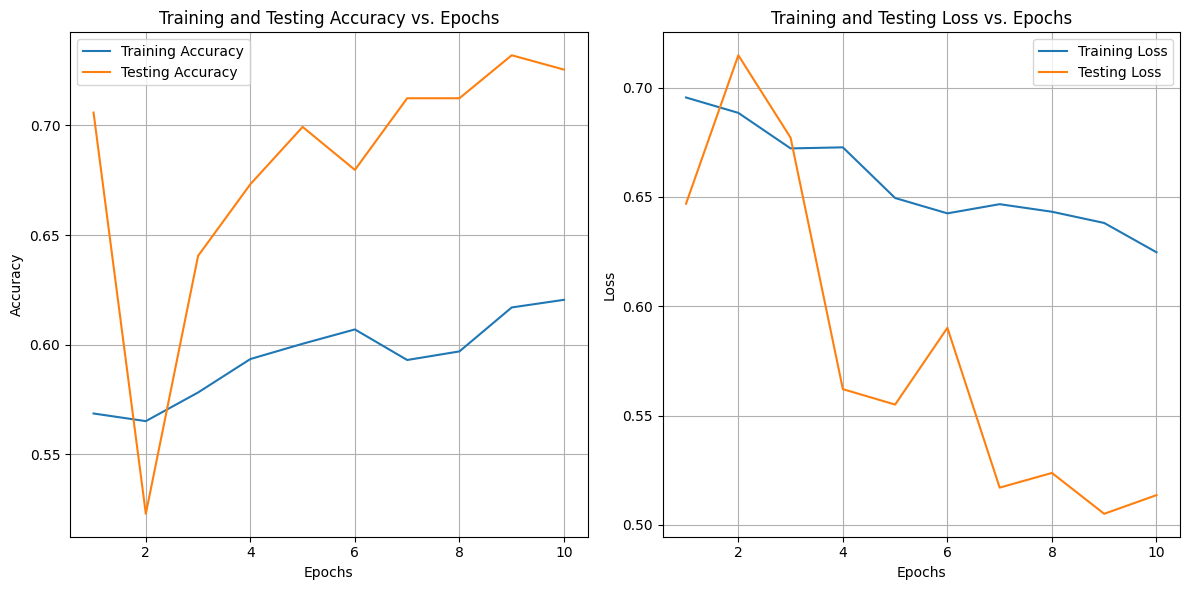

In [ ]:
# Plot training and testing metrics for the last fold
last_fold = fold_histories[-1]
epochs = range(1, len(last_fold['training_accuracy']) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, last_fold['training_accuracy'], label='Training Accuracy')
plt.plot(epochs, last_fold['testing_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, last_fold['training_loss'], label='Training Loss')
plt.plot(epochs, last_fold['testing_loss'], label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()